# Általánosítás-túltanulás hangolása

Olvasd el a kapcsolodó [előadás olvasóleckét](http://www.inf.u-szeged.hu/~rfarkas/ML20/overfitting.html)!

## Gépjármű biztosítási feladat

[Gépjármű biztosítási bináris osztályozási feladatot](https://archive.ics.uci.edu/ml/datasets/Insurance+Company+Benchmark+%28COIL+2000%29) oldunk meg ebben a leckében. Az egyedek itt potenciális ügyfelek és 85 jellemző alapján predikáljuk, hogy az ügyfélt érdekli-e a gépjármű biztosítási ajánlatunk.

In [ ]:
import pandas as pd

# az oszlopok neveit egy külön fájlból olvassuk be
f = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/tic-mld/dictionary.txt",
            encoding="latin-1",
            skiprows=3, 
            header=None,
            nrows=86) # csak 86 oszlopnév kell a fájlból, a fájl többi része érdektelen
colnames = [ s.split()[1] for s in f[0] ] # oszlopneveket stringműveletekkel olvassuk ki

# tanító adatbázis beolvasása:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/tic-mld/ticdata2000.txt", 
            sep="\t", 
            names=colnames)
df

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,...,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,0,...,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,2,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,0,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,0,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,0,...,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,1,1,2,8,0,6,1,2,1,2,6,5,3,2,2,5,2,2,0,0,4,1,3,2,3,3,3,0,9,0,5,1,3,5,4,4,3,3,0,...,6,0,4,0,0,0,0,0,3,0,0,0,3,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0
5818,35,1,4,4,8,1,4,1,4,6,0,3,2,2,5,0,0,9,2,1,1,3,3,2,0,4,5,0,0,3,6,6,1,2,6,3,0,9,0,0,...,0,0,0,0,1,0,0,3,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
5819,33,1,3,4,8,0,6,0,3,5,1,4,3,3,4,0,1,8,1,0,0,2,3,5,1,1,1,4,4,7,2,4,0,5,8,1,5,3,1,1,...,6,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
5820,34,1,3,2,8,0,7,0,2,7,2,0,0,4,5,0,2,7,0,2,0,2,4,2,0,0,4,5,0,2,7,5,4,0,9,0,0,5,4,0,...,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
classlabels = df.CARAVAN # osztálycímke az utolsó oszlop (CARAVAN)
features = df.iloc[:,:85] # az első 85 oszlop a jellemzőtér
features

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,...,PWALAND,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,0,...,0,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,0,...,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,0,...,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,1,1,2,8,0,6,1,2,1,2,6,5,3,2,2,5,2,2,0,0,4,1,3,2,3,3,3,0,9,0,5,1,3,5,4,4,3,3,0,...,0,6,0,4,0,0,0,0,0,3,0,0,0,3,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0
5818,35,1,4,4,8,1,4,1,4,6,0,3,2,2,5,0,0,9,2,1,1,3,3,2,0,4,5,0,0,3,6,6,1,2,6,3,0,9,0,0,...,0,0,0,0,0,1,0,0,3,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
5819,33,1,3,4,8,0,6,0,3,5,1,4,3,3,4,0,1,8,1,0,0,2,3,5,1,1,1,4,4,7,2,4,0,5,8,1,5,3,1,1,...,0,6,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5820,34,1,3,2,8,0,7,0,2,7,2,0,0,4,5,0,2,7,0,2,0,2,4,2,0,0,4,5,0,2,7,5,4,0,9,0,0,5,4,0,...,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# a kiértékelő adatbázis jellemzőtere egy külön fájlban van
test_faetures = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/tic-mld/ticeval2000.txt", 
                            sep="\t", 
                            names=colnames[:-1])
test_faetures

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,...,PWALAND,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,4,2,8,0,6,0,3,5,0,4,1,1,8,2,2,6,0,0,1,2,6,1,0,2,1,5,3,1,8,8,1,1,8,1,3,3,3,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,6,1,3,2,2,0,5,0,4,5,2,2,1,4,5,5,4,0,5,0,0,4,0,0,4,3,0,2,1,3,6,9,0,0,7,2,1,1,5,4,...,0,6,0,4,0,0,0,0,0,3,0,0,0,4,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0
2,39,1,3,3,9,1,4,2,3,5,2,3,2,3,6,2,4,4,2,1,1,3,2,2,1,1,5,2,1,1,8,6,2,2,6,3,2,4,3,1,...,0,6,0,0,0,0,0,0,0,4,0,0,0,4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,9,1,2,3,3,2,3,2,4,5,4,1,2,4,4,2,4,4,2,1,1,5,1,2,3,1,3,2,2,3,6,7,2,1,7,2,2,5,3,1,...,0,5,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,31,1,2,4,7,0,2,0,7,9,0,0,0,6,3,0,0,9,0,0,0,2,4,4,0,0,0,7,2,9,0,7,2,0,9,0,5,4,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,33,1,2,4,8,0,7,2,0,5,2,2,2,6,2,0,3,6,5,0,0,1,0,4,2,0,2,4,2,4,5,4,4,2,3,6,3,6,0,0,...,0,6,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3996,24,1,2,3,5,1,5,1,3,4,2,4,4,4,2,2,4,4,2,0,0,3,3,3,1,1,2,5,1,7,2,6,0,3,7,2,3,3,2,2,...,0,6,0,0,0,0,0,0,0,6,0,0,0,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3997,36,1,2,3,8,1,5,1,3,7,0,2,2,5,3,2,3,4,2,0,0,3,4,2,1,1,3,5,0,7,2,6,1,2,6,3,2,5,3,0,...,0,6,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3998,33,1,3,3,8,1,4,2,3,7,1,2,2,3,4,1,3,5,1,1,1,2,3,3,2,2,2,4,1,4,5,6,2,2,7,2,1,4,4,1,...,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# és a kiértékelő adatbázis címkéi is egy külön fájlban vannak
# 2000-ben egy verseny zajlott ezen az adatbázison, ahol a versenyzőknek a kiértékelő adatbázisra kellett predikciót beküldeni
# a verseny után adták csak a kiértékelő adatbázis címkézését
test_classlabels = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/tic-mld/tictgts2000.txt",
                               header=None)
test_classlabels.shape

(4000, 1)

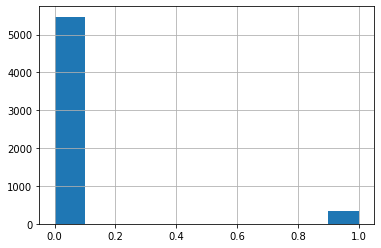

In [ ]:
classlabels.hist() # nagyon kiegyensúlyozatlan a címkeeloszlás (nagyon kevés 1-es osztály van)

Ahhoz, hogy ne "kukucskáljunk" a kiértékelő adatbázisra, azt csak a legvégső (egyetlen) kiértékelésre használjuk. Ahhoz, hogy különböző gépi tanulási megközelítéseket, illetve azok meta-paramétereit összehasonlítsunk vágjuk a tanító és validációs halmazra az eredeti "tanító adatbázisunkat". Amelyik modell és meta-paraméter a legjobb eredményeket éri el a validációs halmazon, azt fogjuk használni végső modellként.

In [ ]:
# használjuk a címkézett adatunk 25%-át validációs halmaznak
from sklearn.model_selection import train_test_split
train_features, valid_features, train_classlabels, valid_classlabels = train_test_split(features, classlabels, test_size=0.25, random_state=42)
valid_features.shape

(1456, 85)

Tanítsunk egy döntési fát kezdésnek, hogy kicsit ismerkedjünk a feladattal

In [ ]:
from sklearn import tree
dt = tree.DecisionTreeClassifier() # döntési fa osztályozó
dt.fit(train_features, train_classlabels)

DecisionTreeClassifier()

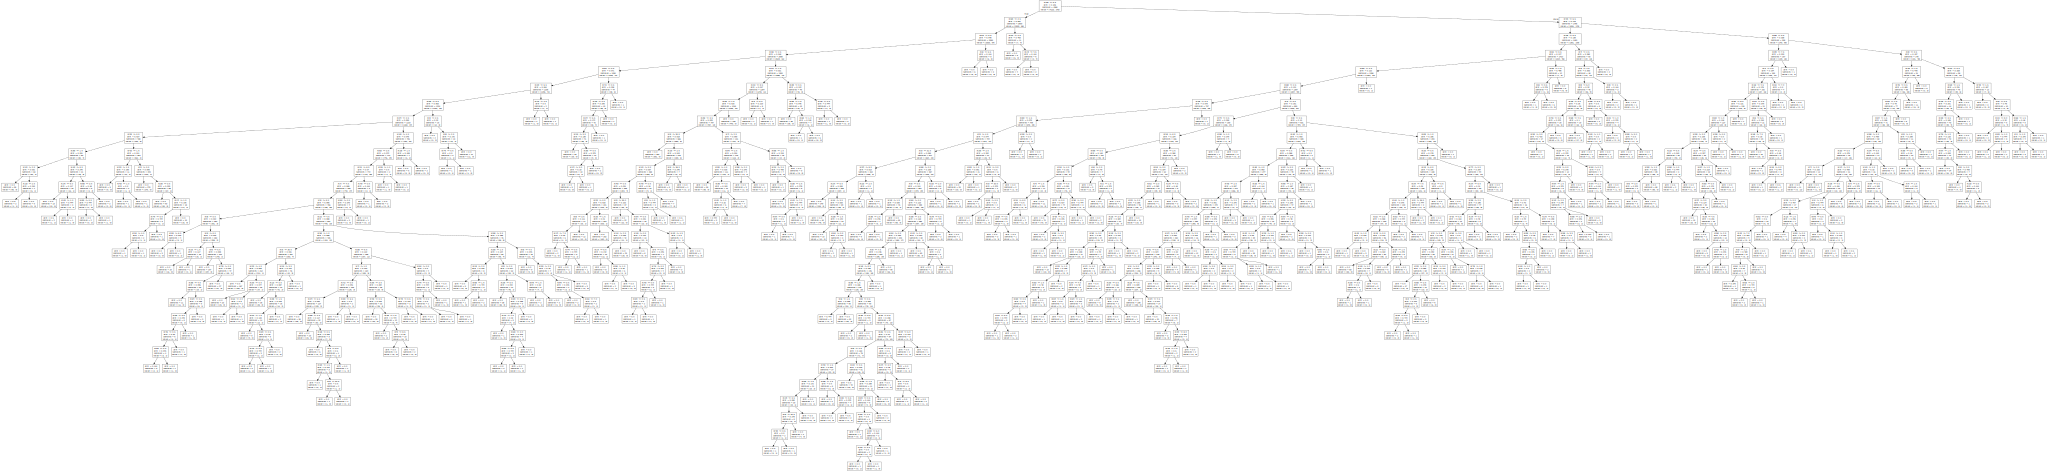

In [ ]:
!apt-get -qq install -y graphviz && pip install -q pydot #Thank you https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d
!pip install graphviz
import pydot
import graphviz
graphviz.Source(tree.export_graphviz(dt, out_file=None))

In [ ]:
prediction = dt.predict(valid_features)
from sklearn.metrics import classification_report
print(classification_report(valid_classlabels, prediction))


              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1351
           1       0.16      0.17      0.16       105

    accuracy                           0.87      1456
   macro avg       0.55      0.55      0.55      1456
weighted avg       0.88      0.87      0.88      1456



Arra vagyunk kíváncsiak, hogy kinek érdemes biztosítást ajánlani, ezért az 1-es osztály érdekel minket! **Legyen a kiértékelési metrika az 1-es osztály F1 értéke!**

In [ ]:
from sklearn.metrics import f1_score
f1_score(valid_classlabels, prediction, pos_label=1)

0.16289592760180993

Az alábbiakban a döntési fa, lineáris gép és kNN osztályozókat és meta-paramétereiket tanítsjuk és kiértékeljük a validációs halmazon, hogy kiválasszuk a legjobb modellt (kukucskálás nélkül).

## Döntési fa meta-paraméter hangolása

Döntési fánál a fa mélységével tudjuk szabályozni az általánosítás-túltanulást.

In [ ]:
### különböző fa mélységi értékekkel tanítjuk a fát
valid_f1=[]
train_f1=[]
for d in range(1,40):
  dt = tree.DecisionTreeClassifier(max_depth=d) # döntési fa mélysége
  dt.fit(train_features, train_classlabels)  # tanítunk a tanító adatbázison
  valid_prediction = dt.predict(valid_features)
  valid_f1.append(f1_score(valid_classlabels, valid_prediction, pos_label=1)) # kiértékelés a validációs halmazon
  train_prediction = dt.predict(train_features)
  train_f1.append(f1_score(train_classlabels, train_prediction, pos_label=1)) # a tanító adatbázison is kiértékeljük a túltanulási vizsgálatokhoz

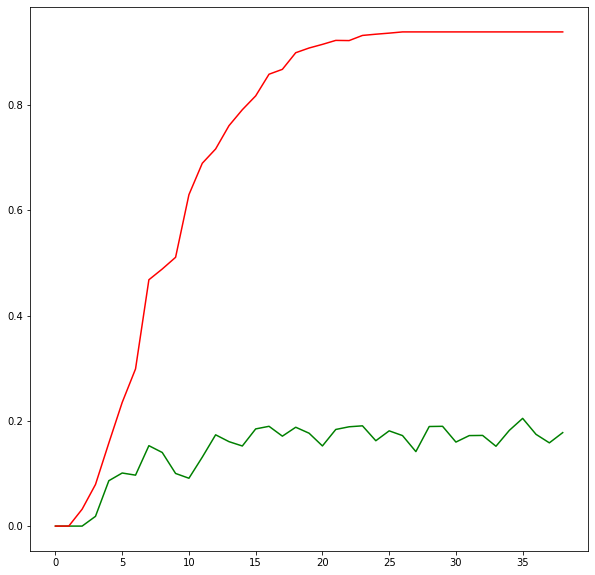

In [ ]:
### jelenítsük meg az eredményeket
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(valid_f1, c="green")
plt.plot(train_f1, c="red")

Valahol 15 és 20 mélység közt lehet a validációs halmazon a maximum. Használjuk a 20-at mint a döntési fa legjobb meta-paramétere

In [ ]:
dt = tree.DecisionTreeClassifier(max_depth=20)
dt.fit(train_features, train_classlabels)  
valid_prediction = dt.predict(valid_features)
print(classification_report(valid_classlabels, valid_prediction))
print("Legjobb döntési fa a validációs halmazon:", f1_score(valid_classlabels, valid_prediction, pos_label=1))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1351
           1       0.22      0.22      0.22       105

    accuracy                           0.89      1456
   macro avg       0.58      0.58      0.58      1456
weighted avg       0.89      0.89      0.89      1456

Legjobb döntési fa a validációs halmazon: 0.21800947867298578


## Lineáris gép meta-paraméter hangolása

Lineáris gépnél a regularizációs tag együtthatóval szabályozhatjuk a általánosítás-túltanulást.

In [ ]:
### különböző regularizációs együtthatók
from sklearn.linear_model import LogisticRegression
valid_f1=[]
train_f1=[]
for l in range(-7,5):
  lin = LogisticRegression(random_state=0, 
                           max_iter=10000, # nehéz feladat a lineáris gépnek, engedjük a defaultnál tovább tanulni
                           class_weight="balanced", # tanulásnál átsúlyozzuk a ritka osztálycímkéket, ez sokat segít lineáris gépeknél
                           C=10**l) # regularizációs együttható 
  lin.fit(train_features, train_classlabels)  
  valid_prediction = lin.predict(valid_features)
  valid_f1.append(f1_score(valid_classlabels, valid_prediction, pos_label=1))
  train_prediction = lin.predict(train_features)
  train_f1.append(f1_score(train_classlabels, train_prediction, pos_label=1))

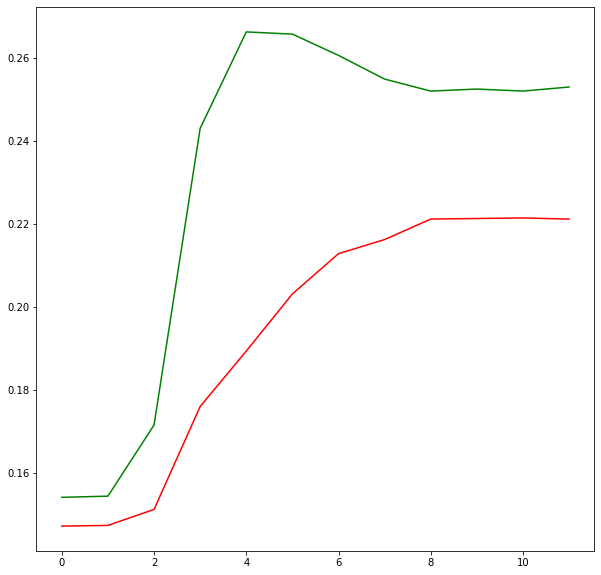

In [ ]:
### jelenítsük meg az eredményeket
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(valid_f1, c="green")
plt.plot(train_f1, c="red")

A lineáris modellek nagyon rosszak a "magolásban", ezért a tanító adatbázison is csak a validációs adatbázis értékkészletén mozog az F1 :( Megjegyezzük, hogy az 1-es osztálycímkére nagyon kevés tanító példánk van...

Mindenesetre a validációs halmazon a 4. meta-paraméter érték (`C=10ˆ-3`) a legjobb.

In [ ]:
lin = LogisticRegression(random_state=0, max_iter=10000, class_weight="balanced", C=10**-3)
lin.fit(train_features, train_classlabels)  
valid_prediction = lin.predict(valid_features)
print(classification_report(valid_classlabels, valid_prediction))
print("Legjobb logisztikus regresszió a validációs halmazon:", f1_score(valid_classlabels, valid_prediction, pos_label=1))

              precision    recall  f1-score   support

           0       0.97      0.72      0.83      1351
           1       0.16      0.70      0.27       105

    accuracy                           0.72      1456
   macro avg       0.57      0.71      0.55      1456
weighted avg       0.91      0.72      0.79      1456

Legjobb logisztikus regresszió a validációs halmazon: 0.26618705035971224


Sok mindent kipróbáltam annak érdekében, hogy a tanító adatbázis bemagolására (magas tanító F1-ek elérésére) késznyerítsem a lineáris gépet, de nem jártam túl sok sikerrel. Ebben a feladatban van néhány jellemző aminek értéke inkább diszkrét (lásd [leírás](https://https://archive.ics.uci.edu/ml/machine-learning-databases/tic-mld/dictionary.txt)), ezért kipróbáltam a jellemzők OneHotEncodolását is. Ezzel a tanítón kb 42 F1ig ment fel, a validásciós halmazon csak 1-2 százalékpontot javultak az eredmények. Ha valakinek sikerül lineáris gépet (SGDClassifier vagy LogisticRegression) 90 fölé vinni a tanító halmazon megadom a kurzusra a jeles(5) osztályzatot ;)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
ohe_features = ohe.fit_transform(train_features)
ohe_valid_features = ohe.transform(valid_features)
ohe_features

## kNN osztályozó meta-paraméter hangolása

kNN-nél maga a k értékkel szabályozhatjuk az általánosítás-túltanulást.

In [ ]:
### kNN különböző k értékekkel
from sklearn.neighbors import KNeighborsClassifier
valid_f1=[]
train_f1=[]
for k in range(1,20,2): # páratlan k értékek
  knn = KNeighborsClassifier(n_neighbors=k) # kNN különböző k értékekkel
  knn.fit(train_features, train_classlabels)  
  valid_prediction = knn.predict(valid_features)
  valid_f1.append(f1_score(valid_classlabels, valid_prediction, pos_label=1))
  train_prediction = knn.predict(train_features)
  train_f1.append(f1_score(train_classlabels, train_prediction, pos_label=1))

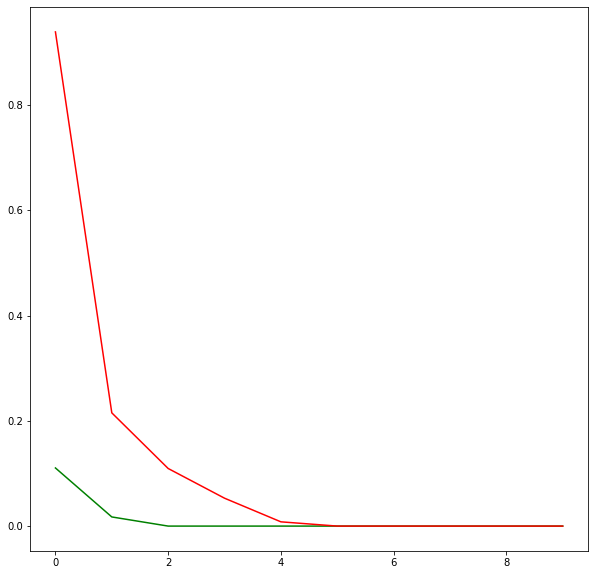

In [ ]:
### jelenítsük meg az eredményeket
plt.figure(figsize=(10,10))
plt.plot(valid_f1, c="green")
plt.plot(train_f1, c="red")

k=1 a legjobb meta-paraméter érték.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_features, train_classlabels)  
valid_prediction = knn.predict(valid_features)
print(classification_report(valid_classlabels, valid_prediction))
print("Legjobb kNN a validációs halmazon:", f1_score(valid_classlabels, valid_prediction, pos_label=1))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1351
           1       0.13      0.10      0.11       105

    accuracy                           0.89      1456
   macro avg       0.53      0.52      0.53      1456
weighted avg       0.87      0.89      0.88      1456

Legjobb kNN a validációs halmazon: 0.11049723756906077


## sklearn gridSearch
A `sklearn` támogatja a metaparaméter hangolást. Az összes lehetséges kombinációban lefuttatja a gépi tanulási kísérletet.

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

parameters = {'kernel':['linear', 'rbf'], 'C':[100, 10, 1]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters,
                   cv = 3,
                   scoring =  make_scorer(f1_score, pos_label=1),
                   verbose=3)
clf.fit(features, classlabels)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..............C=100, kernel=linear;, score=0.000 total time=  32.1s
[CV 2/3] END ..............C=100, kernel=linear;, score=0.000 total time=  31.5s
[CV 3/3] END ..............C=100, kernel=linear;, score=0.000 total time=  38.8s
[CV 1/3] END .................C=100, kernel=rbf;, score=0.030 total time=   1.0s
[CV 2/3] END .................C=100, kernel=rbf;, score=0.031 total time=   0.9s
[CV 3/3] END .................C=100, kernel=rbf;, score=0.016 total time=   0.9s
[CV 1/3] END ...............C=10, kernel=linear;, score=0.000 total time=   7.7s
[CV 2/3] END ...............C=10, kernel=linear;, score=0.000 total time=   7.3s
[CV 3/3] END ...............C=10, kernel=linear;, score=0.000 total time=   5.4s
[CV 1/3] END ..................C=10, kernel=rbf;, score=0.000 total time=   0.8s
[CV 2/3] END ..................C=10, kernel=rbf;, score=0.000 total time=   0.8s
[CV 3/3] END ..................C=10, kernel=rbf;,

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [100, 10, 1], 'kernel': ['linear', 'rbf']},
             scoring=make_scorer(f1_score, pos_label=1), verbose=3)

In [ ]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [ ]:
clf.best_estimator_

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Kiértékelés

Végül a Logisztikus Regresszió `C=10ˆ-3` meta-paraméter bizonyult a legjobbnak a validációs halmazon. Értékeljük ki legvégül ezt a modellt a kiértékelő adatbázison!

Ha behangoltuk a paramétereket, használhatjuk a teljes tanító adatbázist a végső modell tanítására:

In [ ]:
### újratanítás teljes tanítón
lin = LogisticRegression(random_state=0, max_iter=10000, class_weight="balanced", C=10**-3)
lin.fit(features, classlabels)  

LogisticRegression(C=0.001, class_weight='balanced', max_iter=10000,
                   random_state=0)

In [ ]:
# kiértékelés a végső kiértékelő adatbázison
prediction = lin.predict(test_faetures)
print(classification_report(test_classlabels, prediction))

              precision    recall  f1-score   support

           0       0.97      0.68      0.80      3762
           1       0.11      0.63      0.19       238

    accuracy                           0.68      4000
   macro avg       0.54      0.66      0.49      4000
weighted avg       0.92      0.68      0.76      4000



### baseline

Mindig hasonlítsuk eredményeinket egy baseline megoldáshoz!
Ha egy osztályra fókuszálunk a most frequent class osztályozási baseline nem értelmetlen. Építsünk szabályalapú baselinet, ami egyetlen jellemző alapján dönt. Melyik a legfontosabb jellemző?

A döntési fa gyökerébe a 46-os jellemző került.

Lineáris gépeknél a legnagyobb abszolút értékű súlyt kapott jellemző járul hozzá legjobban a döntéshez:

In [ ]:
abs(lin.coef_).argmax()

46

In [ ]:
colnames[46]

'PPERSAUT'

A Logisztikus Regresszió szerint is a PPERSAUT nevű jellemző a legfontosabb.

In [ ]:
pd.crosstab(features.iloc[:,46], classlabels) # 46-os jellemző és osztálycímke együttelőfordulásai a tanító adatbázison

CARAVAN,0,1
PPERSAUT,,
0,2773,72
4,1,0
5,599,14
6,2057,262
7,41,0
8,3,0


In [ ]:
### Legyen a baseline szabályunk, hogy 'HA PPERSAUT=6 AKKOR predikálj 1-et EGYÉBKÉNT 0-t'
baseline = (test_faetures.iloc[:,46] == 6).astype(int) # True/False értékeket 1/0-ra konvertálja az astype(int)
print(classification_report(test_classlabels, baseline))

              precision    recall  f1-score   support

           0       0.97      0.62      0.75      3762
           1       0.10      0.66      0.17       238

    accuracy                           0.62      4000
   macro avg       0.53      0.64      0.46      4000
weighted avg       0.92      0.62      0.72      4000



# Tanulási görbe

A tanító adatbázis mérete, hogyan befolyásolja az eredményeket?

In [ ]:
from sklearn.linear_model import LogisticRegression
valid_f1=dict()
l=-3
for s in range(50,4366,100):
  lin = LogisticRegression(random_state=0, 
                           max_iter=10000, # nehéz feladat a lineáris gépnek, engedjük a defaultnál tovább tanulni
                           class_weight="balanced", # tanulásnál átsúlyozzuk a ritka osztálycímkéket, ez sokat segít lineáris gépeknél
                           C=10**l) # regularizációs együttható 
  lin.fit(train_features[:s], train_classlabels[:s])  
  valid_prediction = lin.predict(valid_features)
  valid_f1[s] = f1_score(valid_classlabels, valid_prediction, pos_label=1)

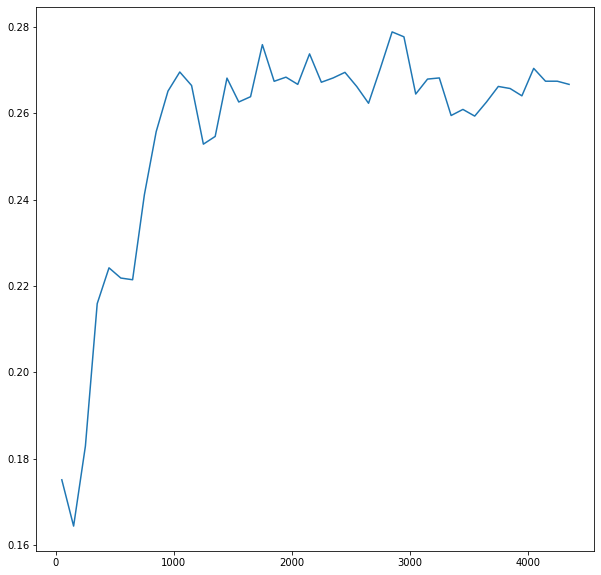

In [ ]:
lists = sorted(valid_f1.items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
plt.figure(figsize=(10,10))
plt.plot(x,y)

# Gépi tanulási kísérletek nyilvántartása

Ha nem akarjuk elfelejteni és össze-vissza tárolni az egyes kísérletek eredményeit, akkor erre vannak (már) eszközök, pl [Weights & Biasese](https://wandb.ai/), lásd [colab tutorial](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/intro/Intro_to_Weights_%26_Biases.ipynb)

In [ ]:
!pip install wandb -qqq
import wandb

     |████████████████████████████████| 1.7 MB 9.3 MB/s 
     |████████████████████████████████| 97 kB 5.8 MB/s 
     |████████████████████████████████| 180 kB 65.1 MB/s 
     |████████████████████████████████| 139 kB 57.2 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 


In [ ]:
# Log in to your W&B account
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: ERROR API key must be 40 characters long, yours was 12


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


In [ ]:
 wandb.init(
      project="MLora", 
      config={
      "depth": 4,
      "architecture": "DT",
      "dataset": "biztositas"})
 
wandb.log({"f1": 23, "trainin_time": 3.5})

wandb.finish()

In [ ]:
from sklearn.linear_model import LogisticRegression

wandb.init(project="MLora", 
          config={
          "max_iter": 10000,
          "approach": "LogReg",
          "dataset": "biztositas"})
  
for l in range(-7,5):
  lin = LogisticRegression(random_state=0, 
                           max_iter=10000, # nehéz feladat a lineáris gépnek, engedjük a defaultnál tovább tanulni
                           class_weight="balanced", # tanulásnál átsúlyozzuk a ritka osztálycímkéket, ez sokat segít lineáris gépeknél
                           C=10**l) # regularizációs együttható 
  lin.fit(train_features, train_classlabels)  
  valid_prediction = lin.predict(valid_features)
  train_prediction = lin.predict(train_features)
  wandb.log({"C" : 10**l,
             "train_f1": f1_score(train_classlabels, train_prediction, pos_label=1),
             "valid_f1": f1_score(valid_classlabels, valid_prediction, pos_label=1)})
  
wandb.finish()

# Gyakorló feladat

Tanuljuk meg a fehér borok minőségének becslését! Hajts végre gépi tanulási kísérleteket [ezen feladat](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) fehér bor [adattábláján](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv). Válaszd ki a megfelelő gépi tanulási megközelítést és hangold be annak általánosítás-túltanulás meta-paraméterét!